<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/kaggle_dataset_quality_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
The data came from:
https://www.kaggle.com/andrewmvd/car-plate-detection



This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

## Wegiths and Biases

In [197]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(project="car_plate_probs_clusters",
           config={
               "batch_size": 32,
               "learning_rate": 0.01,
               "dataset": "Kaggle-Car-Plate",
           })

## Prepare the data

Import libraries

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [6]:
IMAGE_SIZE = 224
DATA_ROOT = "./drive/MyDrive/data/Kaggle_license_plates"

In [7]:
# import os
# for dirname, _, filenames in os.walk(DATA_ROOT):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [8]:
DATA_ROOT

'./drive/MyDrive/data/Kaggle_license_plates'

We create the variable X containing all the images of cars by resizing them.



In [9]:
img_dir = DATA_ROOT + "/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X_raw=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [10]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmin), int(ymin), int(xmax), int(ymax)]
        

In [11]:

label_dir = DATA_ROOT + "/annotations"
text_files = [DATA_ROOT + '/annotations/'+f for f in sorted(os.listdir(label_dir))]

y_raw=[]
for f in text_files:
    # print(f)
    y_raw.append(resizeannotation(f))

In [12]:
def print_file(text_file):
  with open(text_file, "r") as file:
    for line in file:
      print(line)

We check X and y shape

In [13]:
print(np.array(X_raw).shape)
print(np.array(y_raw).shape)

(433, 224, 224, 3)
(433, 4)


In [14]:
def noise_annotation(y, scale):
  y_noise = []
  for y1 in y:
    y1_noise = []
    for e in y1:
      y1_noise.append(int(np.random.normal(loc=e, scale=scale, size=1)))
    y_noise.append(y1_noise)
  return y_noise

# print("original: ", y_raw[0])
# y_noise = noise_annotation(y_raw, 5)
# print("with noise: ", y_noise[0])

And we display the first eighteen image of the dataset : 

In [15]:
import matplotlib.patches as patches

def create_rect(y, color):
  width = y[2] - y[0]
  height = y[3] - y[1]
  return patches.Rectangle((y[0], y[1]),
                            width, height,
                            edgecolor=color, fill=False)



## Transform & normalize data

In [16]:
#Transforming in array
X = np.array(X_raw)
y = np.array(y_raw)

In [17]:
#Renormalisation
X = X / IMAGE_SIZE
y = y / IMAGE_SIZE

We split our dataset in two : training set/testing set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

### Import libraries

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions

## Plot annotation boxes

In [20]:
def plot_with_boxes(X, y1, y2):
  fig = plt.figure(figsize=(20,40))
  for i in range(0,10) :
      axis = fig.add_subplot(10, 5, i+1)
      plt.axis('off')
      image = X[i]

      rect_ori = create_rect(y1[i], (0, 255/255, 0))
      rect_noise = create_rect(y2[i], (255/255, 0, 0))
      axis.add_patch(rect_ori)
      axis.add_patch(rect_noise)

      # Don't use this method as this leaves the annotations in the images
      # image = cv2.rectangle(X[i],
      #                       (y[i][0], y[i][1]),
      #                       (y[i][2], y[i][3]),
      #                       (0, 255, 0))
      # image = cv2.rectangle(image,
      #                       (y_noise[i][0], y_noise[i][1]),
      #                       (y_noise[i][2], y_noise[i][3]),
      #                       (255, 0, 0))
      plt.imshow(np.clip(image, 0, 1))

# plot_with_boxes(X_raw, y_raw, y_noise)

# Clustering

## Run K Means clustering on data

The Elbow method found 11 to be optimal clusters, but given the small number of data, we can choose a smaller number of clusters for the experiments.

Ideally, we want to:

1. Ensure that we have the same distributions for train, validation and test datasets.
2. Pick uniformally across various dataset clusters.
3. Observe any discrepancies across clusters.
4. Find the minimum set of training sets for optimal performance.


In [21]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X

import numpy as np
import os
import sys

#Calculate similar matrics
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim,np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim/norms/norms.T)

def get_feature_maps(input):
    # #Convert to VGG input format
    # NB: This messes up the existing data so skipping it
    #   similarity measures do not seem to be affected by this.
    # vgg_input = preprocess_input(input)

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights = "imagenet", include_top=False)

    #Get features
    # feature_maps = model.predict(vgg_input)
    feature_maps = model.predict(input)

    return feature_maps, model

    # #Calculate similar metrics
    # features_compress = features.reshape(len(y_test), 7*7*512)
    # sim = cosine_similarity(features_compress)

# model_vgg16, feature_maps = get_feature_maps(X)

## K Means Clustering
Run k means clustering on the dataset.

## Cluster data using features maps

In [22]:
fm_train, _ = get_feature_maps(X_train)
fm_val, _ = get_feature_maps(X_val)
fm_test, _ = get_feature_maps(X_test)

58892288/58889256 [==============================] - 1s 0us/step


In [23]:
from sklearn import preprocessing  # to normalise existing X

fm_train_normalized = preprocessing.normalize(fm_train.reshape(len(fm_train), -1))
fm_val_normalized = preprocessing.normalize(fm_val.reshape(len(fm_val), -1))
fm_test_normalized = preprocessing.normalize(fm_test.reshape(len(fm_test), -1))

In [24]:
K = 7

clusters_train = KMeans(n_clusters=K, random_state=0).fit(fm_train_normalized)
clusters_val = KMeans(n_clusters=K, random_state=0).fit(fm_val_normalized)
clusters_test = KMeans(n_clusters=K, random_state=0).fit(fm_test_normalized)

In [25]:
histo_train, bins = np.histogram(clusters_train.labels_, bins=range(K + 1))
histo_val, _ = np.histogram(clusters_val.labels_, bins=range(K + 1))
histo_test, _ = np.histogram(clusters_test.labels_, bins=range(K + 1))

(array([ 6., 10.,  3.,  9., 50.,  6.,  3.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 1 Patch objects>)

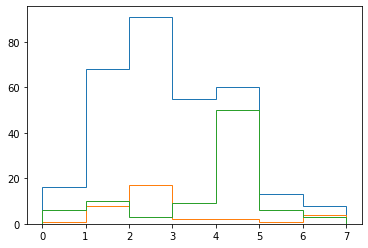

In [26]:
plt.hist(bins[:-1], bins, weights=histo_train, histtype='step', label='train')
plt.hist(bins[:-1], bins, weights=histo_val, histtype='step', label='val')
plt.hist(bins[:-1], bins, weights=histo_test, histtype='step', label='test')

In [27]:
bins, cluster_train_counts = np.unique(clusters_train.labels_, return_counts=True)
bins, cluster_train_counts

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([16, 68, 91, 55, 60, 13,  8]))

In [28]:
def to_cluster_ids(bins, data):
  cluster_ids = dict()
  for cluster_id in bins:
    cluster_ids[cluster_id] = np.where(data == cluster_id)[0]
  return cluster_ids

cluster_ids_train = to_cluster_ids(range(K), clusters_train.labels_)
cluster_ids_val = to_cluster_ids(range(K), clusters_val.labels_)
cluster_ids_test = to_cluster_ids(range(K), clusters_test.labels_)

In [29]:
X_train[cluster_ids_train[0]].shape
y_train[cluster_ids_train[0]].shape

(16, 4)

In [30]:
def create_dataset(X, y, ids):
  X_new = []
  y_new = []

  for id in ids:
    X_new.append(X[id])
    y_new.append(y[id])
  return np.array(X_new), np.array(y_new)

## Plot each cluster

In [31]:
def plot_images(X, y, ids):
  fig = plt.figure(figsize=(20,40))
  i = 0
  for id in ids:
    if i > 49:
      break

    axis = fig.add_subplot(10, 5, i+1)
    i += 1
    plt.axis('off')
    image = X[id]

    rect_ori = create_rect(y[id]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)
    plt.imshow(np.clip(image, 0, 1))

# Metrics

In [39]:
#GT Boxes
gt_boxes= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
#Pred Boxes
pred_boxes={"img_00285.png": {"boxes":
                             [[330, 463, 387, 505],
                              [356, 456, 391, 521],
                              [420, 433, 451, 498],
                              [468, 435, 520, 521]],
                              "scores": [0.0739, 0.0843, 0.091, 0.1008]}}

def create_gt_boxes(X_test):
  gt_boxes = dict()
  for id in range(len(X_test)):
    gt_boxes[str(id)] = [list(X_test[id].tolist())]
  return gt_boxes

def create_pred_boxes(y_preds, scores):
  pred_boxes = dict()
  for id in range(len(y_preds)):
    pred_boxes[str(id)] =  {
        "boxes": [y_preds[id].tolist()],
        "scores": list(scores[id])
    }
  return pred_boxes

In [40]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

## IOU

In [41]:
# https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
      return 0.0
        # raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        # raise AssertionError("Predicted Bounding Box is not correct",
        #                      x_topleft_p, x_bottomright_p, y_topleft_p, y_bottomright_gt)
      return 0.0
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
      return 0.0

    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
      return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
      return 0.0

    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
      return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [42]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [43]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [141]:
from copy import deepcopy
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        # print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
    
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
# Recalculate image results for this image
            # print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img,
                                      pred_boxes_pruned[img_id]['boxes'],
                                      iou_thr=0.5)
# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            # print(recalls,"Recall")
            # print(      recall_level,"Recall Level")
            # print(       args, "Args")
            # print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [45]:
# this method is borrowed from
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # print("xA:{} yA:{} xB:{} yB:{}".format(xA, yA, xB, yB))
    # print("xB - xA + 1:{} yB - yA + 1:{}".format(xB - xA + 1, yB - yA + 1))

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # print("interArea:{}".format(interArea))

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # print("boxAArea:{} boxBArea:{}".format(boxAArea, boxBArea))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

# This also works, but does not quite work in some cases
# https://medium.com/koderunners/intersection-over-union-516a3950269c
def bb_iou2(box1, box2):
    x1, y1, x12, y12 = box1
    x2, y2, x22, y22 = box2
    w1 = x1 - x12
    h1 = y1 - y12
    w2 = x2 - x22
    h2 = y2 - y22
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

## Calculate mAP

In [140]:
# averages out sample predictions (input data)x(samples)x(prediction points = 4)
# into (input data)x(averaged prediction points = 4)
def average_sample_preds(y_sample_preds):
  averages = []
  for y_pred in y_sample_preds:
    averages.append([np.mean(y_pred[:, i]) for i in range(y_pred.shape[1])])
  return np.array(averages)

def calculate_map(y_test, y_preds, threshold=0.5):
  y_test_scaled = y_test*IMAGE_SIZE
  y_pred_scaled = y_preds*IMAGE_SIZE
  scores = [[calc_iou(y_test_scaled[id], y_pred_scaled[id])] for id in range(len(y_test_scaled))]

  gt_boxes = create_gt_boxes(y_test_scaled)
  pred_boxes = create_pred_boxes(y_pred_scaled, scores)

  map = get_avg_precision_at_iou(gt_boxes=gt_boxes, pred_bb=pred_boxes)
  # print("mAP:{:.2}".format(map['avg_prec']))
  return map

# Models

### Create CNN Model

In [47]:
# Create the model
def create_model():
  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(4, activation="sigmoid"))

  model.layers[-6].trainable = False
  model.summary()

  return model

### Create Probability Model

In [48]:
kl_divergence_fn = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(y_train.shape[0], dtype=tf.float32)

# Create the model
def create_prob_model():
  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(tfp.layers.DenseFlipout(4, activation="sigmoid", kernel_divergence_fn=kl_divergence_fn))

  model.layers[-6].trainable = False
  model.summary()

  return model

# Setup experiment

In [49]:
def scale_up(rect):
  rect = rect*IMAGE_SIZE
  return int(rect[0]), int(rect[1]), int(rect[2]), int(rect[3])

def plot_predictions(X, y_gt, y_preds):
  fig = plt.figure(figsize=(20,40))
  end_id = len(y_gt) if len(y_gt) < 50 else 50

  y_preds_avg = average_sample_preds(y_preds)
  stds = np.std(y_preds, axis=1)
  mean_stds = np.mean(stds, axis=1)

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_rect(y_gt[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)

    # for each test image, there could be multiple predictions
    for y_pred in y_preds[i]:
      rect_pred = create_rect(y_pred*IMAGE_SIZE, (255/255, 0, 0))
      axis.add_patch(rect_pred)

    iou = bb_iou(y_preds_avg[i]*IMAGE_SIZE, y_gt[i]*IMAGE_SIZE)
    plt.title("IOU: {:0.2f} std: {:0.2f}".format(iou, mean_stds[i]))
    # plt.title("mean std: {:0.2f}".format(mean_stds[sample_ids[i]]))
    plt.imshow(np.clip(image, 0, 1))

def plot_predictions_old(X_test, y_test, y_pred):
  fig = plt.figure(figsize=(20,40))

  end_id = len(y_test) if len(y_test) < 50 else 50
  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.subplot(10,5,i+1)
    plt.axis('off')

    image = X_test[i]

    # for j in range(0, len(y_preds[i])):
    #   # rect_pred = create_rect(y_preds[i][j]*IMAGE_SIZE, (255/255, 0, 0))
    #   rect_pred = create_rect(y_preds[y_preds[i]][j]*IMAGE_SIZE, (255/255, 0, 0))
    #   axis.add_patch(rect_pred)

    y_pred1 = y_pred[i]*IMAGE_SIZE
    y_pred1 = int(y_pred1[0]), int(y_pred1[1]), int(y_pred1[2]), int(y_pred1[3])

    y_gt1 = y_test[i]*IMAGE_SIZE
    y_gt1 = int(y_gt1[0]), int(y_gt1[1]), int(y_gt1[2]), int(y_gt1[3])

    rect_ori = create_rect(y_gt1, (0, 255/255, 0))
    rect_pred = create_rect(y_pred1, (255/255, 0, 0))
    axis.add_patch(rect_ori)
    axis.add_patch(rect_pred)

    iou = bb_iou(y_pred1, y_gt1)
    iou2 = bb_iou2(y_pred1, y_gt1)

    plt.title("IOU: {:0.2f} IOU2:{:0.2f}".format(iou, iou2))
    plt.imshow(image)

In [50]:
def fix_predictions(y_preds):
  errors = dict()

  for id in range(len(y_preds)):
    for sample_id in range(len(y_preds[id])):
      x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
      if x_topleft_p > x_bottomright_p:
        # y_preds[id][sample_id][0] = x_bottomright_p
        # y_preds[id][sample_id][2] = x_topleft_p
        y_preds[id][sample_id][2] = x_topleft_p + .01/IMAGE_SIZE
        errors[id] = 1
        # x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
        # print("Fixed xbr", x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p)
      if y_topleft_p > y_bottomright_p:
        # y_preds[id][sample_id][1] = y_bottomright_p
        # y_preds[id][sample_id][3] = y_topleft_p
        y_preds[id][sample_id][3] = y_topleft_p + .01/IMAGE_SIZE
        # errors += 1
        errors[id] = 1
        # x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = y_preds[id][sample_id]
        # print("Fixed ybr", x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p)
  print("Fixed predictions: {}/{} {}".format(len(errors), len(y_preds), errors))
  return y_preds

In [51]:
def run_experiment(model,
                   X_train, y_train,
                   X_val, y_val,
                   X_test, y_test,
                   epochs, batch_size):

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  train_history = model.fit(x=X_train, y=y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1,
                            callbacks=[wandb.keras.WandbCallback(data_type="image",
                            save_model=False)])
  # Test
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Score : %.2f%%" % (scores[1]*100))

  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=int(100))

  print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

  y_preds = sample_predictions(model, X_test, iterations=1)
  # y_preds = model.predict(X_test)

  # TODO:
  # Hack to fix erroneous predictions
  y_preds = fix_predictions(y_preds)
  plot_predictions(X_test, y_test, y_preds)

  averaged_predictions = average_sample_preds(y_preds)
  map = calculate_map(y_test, averaged_predictions)
  return model, y_preds, map

### Sample predictions

In [52]:
def sample_predictions(model, samples, iterations=10):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(samples).numpy())

    predicted = np.array(predicted)
    # predicted = np.concatenate(predicted, axis=1)

    # predicted = np.array([model_prob.predict(np.expand_dims(X_test[1], [0])) for i in range(iterations)])
    # predicted = np.concatenate(predicted, axis=1)
    reshaped = np.array([predicted[:, column] for column in range(0, predicted.shape[1])])

    return reshaped
    
def calculate_mean_std(model, X, cluster_ids):
  mean_stds = []
  for cluster_id in range(len(cluster_ids)):
    predicted = sample_predictions(model, X[cluster_ids[cluster_id]], iterations=50)

    stds = np.std(predicted, axis=1)
    mean_std = np.mean(stds, axis=1)
    # print(mean_std)
    print("{}: mean std: {:0.2f}".format(cluster_id, np.mean(mean_std)))
    mean_stds.append(mean_std)
  
  return mean_stds

# Train

## Train with clean data
Everything is clean. y_train and y_val are all clean labels.

In [ ]:
model_clean_train = create_model()
model_clean_train, y_pred_clean_train, map = run_experiment(model_clean_train,
                                                            X_train, y_train,
                                                            X_val, y_val,
                                                            X_test, y_test,
                                                            50, 32)

## Train on noisy data

In [ ]:
noise_factor = 10
y_train_noise = noise_annotation(y_train * IMAGE_SIZE, noise_factor)
y_train_noise = np.array(y_train_noise)/IMAGE_SIZE
y_train_noise

model_train_noise = create_model()

model_train_noise, y_pred_train_noise, map_train_noise = run_experiment(model_train_noise,
                                                                        X_train, y_train_noise,
                                                                        X_val, y_val,
                                                                        X_test, y_test, 50, 32)

## Train with probability

In [ ]:
model_prob = create_prob_model()

model_prob, y_pred_prob, map_prob = run_experiment(model_prob,
                                                   X_train, y_train,
                                                   X_val, y_val,
                                                   X_test, y_test, 50, 32)

# calculate_mean_std(model_prob_cl_1, X_test, cluster_ids_test)

## Train on noisy data with probability

In [ ]:
noise_clst_id = 1
noise_factor = 10
cluster_ids_train

# print(y_train.shape)
y_train_new = []
for id in range(y_train.shape[0]):
  y = y_train[id]
  # print(y)
  if id in cluster_ids_train[noise_clst_id]:
    y = noise_annotation([y] * IMAGE_SIZE, noise_factor)
    y = np.array(y)/IMAGE_SIZE
  y_train_new.append(y)

y_train_new = np.array(y_train_new)
print(X_train.shape, y_train.shape, y_train_new.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(y_train_new[0])
print(y_train[0])
print(type(y_train))
print(type(y_train_new))
print(y_train_new)
# y_train_noise = noise_annotation(y_train * IMAGE_SIZE, noise_factor)

# model_prob_noise = create_prob_model()
# model_prob_noise, y_pred_prob_noise, map_prob_noise = run_experiment(model_prob_noise,
#                                                                      X_train, y_train,
#                                                                      X_val, y_val,
#                                                                      X_test, y_test, 50, 32)

## Train with probability on clusters

In [ ]:
def find_train_test_diff(cluster_id):
  return len(cluster_ids_train[cluster_id]) - len(cluster_ids_test[cluster_id])

[find_train_test_diff(id) for id in range(7)]

[10, 58, 88, 46, 10, 7, 5]

In [155]:
def predict_on_cluster(model, X_test, y_test, iterations=10):
  y_preds = sample_predictions(model, X_test, iterations=iterations)
  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=1)

  # TODO:
  # Hack to fix erroneous predictions
  y_preds_fixed = fix_predictions(y_preds)
  plot_predictions(X_test, y_test, y_preds_fixed)

  preds_avg = average_sample_preds(y_preds)
  m_ap = calculate_map(y_test, preds_avg)
  # m_aps = []
  # for y_pred in y_preds.shape[1]:
  # for y_pred in y_preds.shape:
    # preds_avg = average_sample_preds(y_pred)
    # for i in range(len(y_pred)):
    #   print("y_test", y_test.shape, "y_pred", y_pred.shape)
    # m_ap = calculate_map(y_test, preds_avg)
    #   m_aps.append(m_ap)

  stds = np.std(y_preds, axis=1)
  mean_std = np.mean(stds, axis=1)

  return y_preds, m_ap, test_accuracy, np.mean(mean_std)

In [ ]:
def predict_on_all_clusters(model, X, y, clst_ids):
  stats = []
  for clst_id in range(len(clst_ids)):
    y_preds, m_ap, accuracy, mstd = predict_on_cluster(model, X[clst_ids[clst_id]], y[clst_ids[clst_id]])

    # stds = np.std(y_preds, axis=1)
    # mean_std = np.mean(stds, axis=1)
    # print(mean_std)
    # print("{}: mean std: {:0.2f}".format(cluster_id, np.mean(mean_std)))

    stats.append((m_ap['avg_prec'], mstd))
    print("{} mAP: {:0.2f} std: {:0.2f} acc: {:0.2f}".format(clst_id, m_ap['avg_prec'],
                                                             mstd,
                                                             accuracy))
  return np.array(stats)

print("***Train***")
stats_train = predict_on_all_clusters(model_prob, X_train, y_train, cluster_ids_train)
print("***Validation***")
stats_val = predict_on_all_clusters(model_prob, X_val, y_val, cluster_ids_val)
print("***Test***")
stats_test = predict_on_all_clusters(model_prob, X_test, y_test, cluster_ids_test)


In [ ]:
model_clean_noise = model_train_noise
print("***Train***")
stats_train = predict_on_all_clusters(model_clean_noise, X_train, y_train, cluster_ids_train)
print("***Validation***")
stats_val = predict_on_all_clusters(model_clean_noise, X_val, y_val, cluster_ids_val)
print("***Test***")
stats_test = predict_on_all_clusters(model_clean_noise, X_test, y_test, cluster_ids_test)


In [ ]:
clst_id = 3
y_preds_clst, m_ap_clst, accuracy_clst, mstd = predict_on_cluster(model_prob, X[cluster_ids_test[clst_id]], y[cluster_ids_test[clst_id]])
print("mAP:{:.02f} accuracy: {:.02f} std: {:.02f}".format(m_ap_clst['avg_prec'], accuracy_clst, mstd))

In [ ]:
clst_id = 4
y_preds_clst, m_ap_clst, accuracy_clst, mstd = predict_on_cluster(model_prob, X[cluster_ids_test[clst_id]], y[cluster_ids_test[clst_id]])
print("mAP:{:.02f} accuracy: {:.02f} std: {:.02f}".format(m_ap_clst['avg_prec'], accuracy_clst, mstd))


In [ ]:
def run_experiment_on_cluster(model, cluster_id):
  X_ttrain = X_train[cluster_ids_train[cluster_id]]
  y_ttrain = y_train[cluster_ids_train[cluster_id]]

  X_tval = X_val[cluster_ids_val[cluster_id]]
  y_tval = y_val[cluster_ids_val[cluster_id]]

  X_ttest = X_test[cluster_ids_test[cluster_id]]
  y_ttest = y_test[cluster_ids_test[cluster_id]]

  batch_size = len(y_ttest)
  model, y_pred, map = run_experiment(model,
                                      X_ttrain, y_ttrain,
                                      X_tval, y_tval,
                                      X_ttest, y_ttest, 50, batch_size)
  
  return model, y_pred, map


model_prob_clst = create_prob_model()
model_clst, y_pred_clst, map_clst = run_experiment_on_cluster(model_prob_clst, 2)

In [ ]:
print("***Train***")
stats_train = predict_on_all_clusters(model_clst, X_train, y_train, cluster_ids_train)
print("***Validation***")
stats_val = predict_on_all_clusters(model_clst, X_val, y_val, cluster_ids_val)
print("***Test***")
stats_test = predict_on_all_clusters(model_clst, X_test, y_test, cluster_ids_test)


***Train***
Fixed predictions:  65
0 mAP: 0.00 std: 0.02
Fixed predictions:  422
1 mAP: 0.00 std: 0.02
Fixed predictions:  1719
2 mAP: 0.91 std: 0.07
Fixed predictions:  385
3 mAP: 0.00 std: 0.03
Fixed predictions:  79
4 mAP: 0.00 std: 0.01
Fixed predictions:  46
5 mAP: 0.00 std: 0.02
Fixed predictions:  107
6 mAP: 0.00 std: 0.04
***Validation***
Fixed predictions:  0
0 mAP: 0.00 std: 0.00
Fixed predictions:  14
1 mAP: 0.00 std: 0.01
Fixed predictions:  127
2 mAP: 0.00 std: 0.03
Fixed predictions:  0
3 mAP: 0.00 std: 0.00
Fixed predictions:  0
4 mAP: 0.00 std: 0.00
Fixed predictions:  14
5 mAP: 0.00 std: 0.05
Fixed predictions:  43
6 mAP: 0.00 std: 0.04
***Test***
Fixed predictions:  8
0 mAP: 0.00 std: 0.01
Fixed predictions:  54
1 mAP: 0.00 std: 0.02
Fixed predictions:  3
2 mAP: 0.00 std: 0.02
Fixed predictions:  30
3 mAP: 0.00 std: 0.02
Fixed predictions:  243
4 mAP: 0.00 std: 0.02
Fixed predictions:  35
5 mAP: 0.00 std: 0.03
Fixed predictions:  0
6 mAP: 0.00 std: 0.00


# Sample predictions

Need to change 3x2x4 to 2x3x4.

(iterations)x(samples)x(coordinates)

to

(samples)x(iterations)x(coordinates)


In [ ]:
plot_predictions(X_test[cluster_ids_test[cluster_id]], y_test[cluster_ids_test[cluster_id]], predicted_cl_1)

# 2 has the most train data
# 4 has the most test data
cluster_id = 3
model_prob_cl_1 = create_prob_model()
model_cl, predicted_cl, map_cl = run_experiment_on_cluster(model_prob_cl_1, cluster_id)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_24 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_flipout_24 (DenseFlipo (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
_________________________________

# Predictions

# Prediction - Appendix

In [ ]:
stds = np.std(predicted, axis=1)
stds.shape
mean_stds = np.mean(stds, axis=1)

min_id = np.argmin(mean_stds)
max_id = np.argmax(mean_stds)

print("min:", min_id, mean_stds[min_id])
print("max:", max_id, mean_stds[max_id])

[print(f"{id} pred std: ", stds[id], f"mean_std:  {mean_stds[id]})") for id in range(len(X_test))]

(87, 4)

In [ ]:
def calculate_area(bbox):
  x_tl, y_tl, x_br, y_br = bbox
  return (x_br - x_tl)*(y_br - y_tl)

In [ ]:
len(sample_preds)

1000

In [ ]:
sample_preds[0]

array([[0.5533793 , 0.40564913, 0.7581168 , 0.65057504]], dtype=float32)

In [ ]:
pred_areas = [calculate_area(bbox[0]) for bbox in sample_preds]

In [ ]:
plt.hist(pred_areas, color='g', alpha=0.4, histtype='step', label='plates', fill=True, linewidth=4, density=True)


In [ ]:
def get_pred_areas(x):
  sample_preds = [model_prob_train.predict(np.expand_dims(x, [0])) for i in range(100)]
  sample_preds = fix_predictions(sample_preds[0])
  pred_areas = [calculate_area(bbox) for bbox in sample_preds]
  return pred_areas

preds0 = get_pred_areas(X_test[0])
preds1 = get_pred_areas(X_test[1])
preds2 = get_pred_areas(X_test[2])

plt.hist(preds0, color='g', alpha=0.4, histtype='step', label='0', fill=True, linewidth=4, density=True)
plt.hist(preds1, color='b', alpha=0.4, histtype='step', label='1', fill=True, linewidth=4, density=True)
plt.hist(preds2, color='r', alpha=0.4, histtype='step', label='2', fill=True, linewidth=4, density=True)

# Appendix for Clustering

## Euclidean distance of images

In [ ]:
from scipy import ndimage
i0 = ndimage.distance_transform_edt(X[0])
i1 = ndimage.distance_transform_edt(X[1])

from scipy.spatial import distance
distance.euclidean(X[0].flatten(), X[1].flatten())

## Run Elbow method to find the optimal K

In [ ]:
def find_k(X, start_k, end_k, distance_fn):
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}
  K = range(start_k, end_k)
  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(X)
      kmeanModel.fit(X)
  
      distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                          distance_fn), axis=1)) / X.shape[0])
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                    distance_fn), axis=1)) / X.shape[0]
      mapping2[k] = kmeanModel.inertia_
  
  return mapping1, mapping2, K, inertias, distortions

normalized_feature_maps = preprocessing.normalize(feature_maps.reshape(len(feature_maps), -1))

# 'euclidean' or 'cosine', etc
mapping1, mapping2, K, inertias, distortions = find_k(normalized_feature_maps, 2, 30, 'cosine')

# kmeans_features = KMeans(n_clusters=11, random_state=0).fit(normalized_feature_maps)

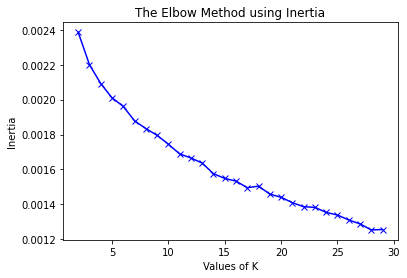

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

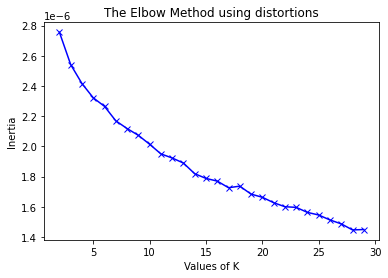

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using distortions')
plt.show()

In [ ]:
fm_train = get_feature_maps(X_train)
fm_val = get_feature_maps(X_val)
fm_test = get_feature_maps(X_train)

## Miscellaneous

In [ ]:
nn = np.vstack([ids, kmeans.labels_])

## Elbow method to find the optimal k
Adapted from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def find_k(X):
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}
  K = range(10, 15)
  
  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(X)
      kmeanModel.fit(X)
  
      distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / X.shape[0])
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]
      mapping2[k] = kmeanModel.inertia_
  
  return mapping1, mapping2, K, inertias, distortions

In [ ]:
mapping1, mapping2, K, inertias, distortions = find_k(X.reshape(len(X),-1))


In [ ]:
print("Elbow", mapping1)
print("mapping2", mapping2)

Elbow {10: 104.03249749637331, 11: 103.10312352976362, 12: 101.6067859189693, 13: 102.26749001212667, 14: 100.82706764423298}
mapping2 {10: 4814616.603107566, 11: 4737997.623679198, 12: 4730363.9842358045, 13: 4692806.712752489, 14: 4614212.104605412}


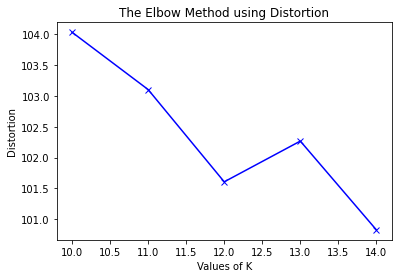

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

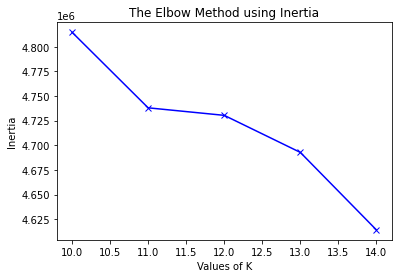

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
print("Elbow", mapping1)
print("mapping2", mapping2)

Elbow {1: 118.65955508616773, 2: 113.81741081301242, 3: 111.26931868426922, 4: 109.70504486918631, 5: 108.31961934906504, 6: 106.71785439442587, 7: 106.50219922318706, 8: 105.88184793285964, 9: 104.80005702139059}
mapping2 {1: 6303128.430595257, 2: 5779384.955971925, 3: 5502443.576369301, 4: 5340225.755338131, 5: 5208051.614096547, 6: 5058304.076693946, 7: 5027380.558469234, 8: 4969258.944017529, 9: 4874786.498505189}


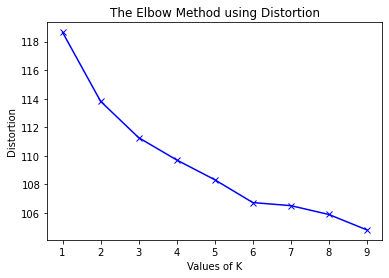

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

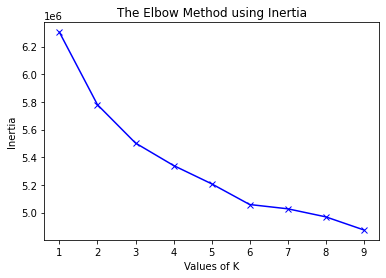

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## Using Cosine similarity
Adapted from:
https://stackoverflow.com/questions/63018098/deep-learning-with-python-cosine-similarity

In [ ]:
np.expand_dims(X, axis=0).shape

(1, 433, 224, 224, 3)

In [ ]:
t_test = np.expand_dims(X[0], axis=0)
t_test.shape

(1, 224, 224, 3)

In [ ]:
t1 = np.expand_dims(X[1], axis=0)

In [ ]:
t_test = np.concatenate((t_test, t1))
t_test.shape

(2, 224, 224, 3)

In [ ]:
np.expand_dims(X, axis=0).shape

(1, 433, 224, 224, 3)

input_5 (433, 7, 7, 512)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


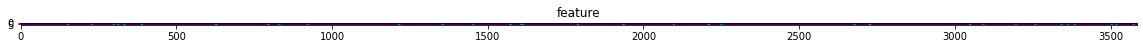

In [ ]:
feature_maps = [features]

# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_vgg16.layers]
for layer_name, feature_map in zip(layer_names, feature_maps):
  print(layer_name, feature_map.shape)
  if len(feature_map.shape) == 4:

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( 'feature' )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

## Plot group images

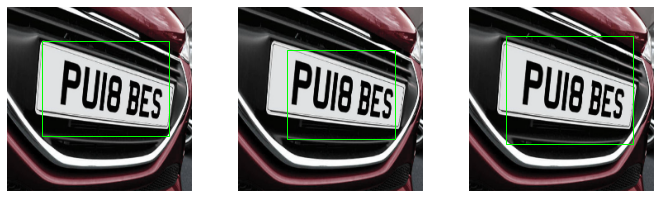

In [ ]:
plot_images(X, y, groups_features[2])

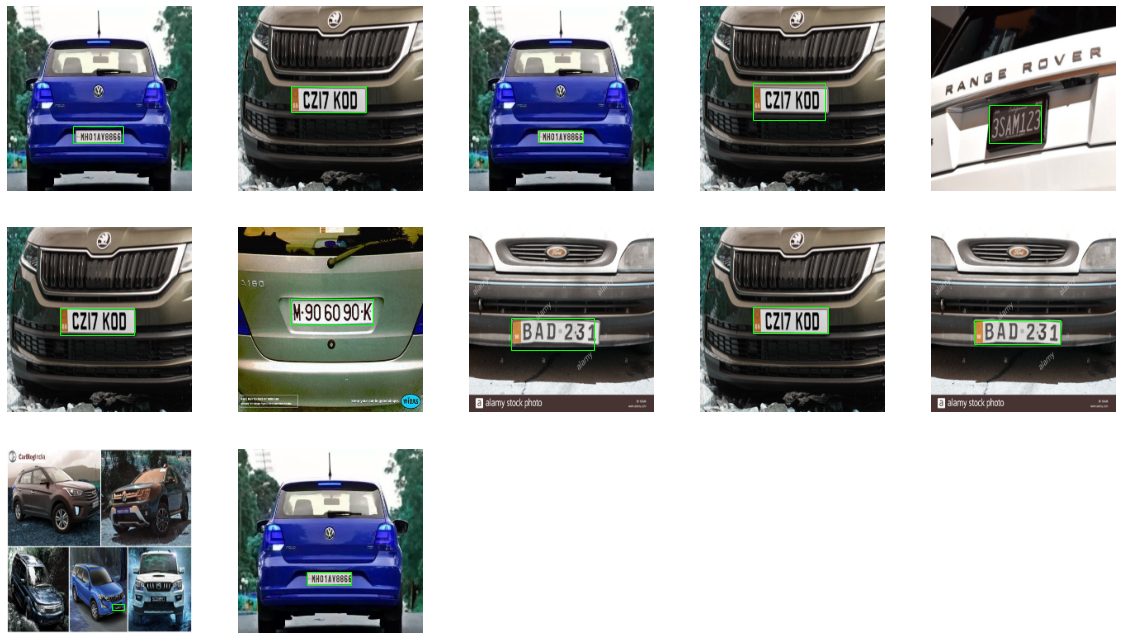

In [ ]:
plot_images(X, y, groups_features[3])

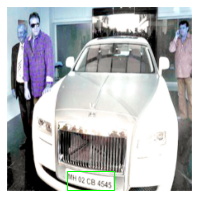

In [ ]:
plot_images(X, y, groups_features[9])

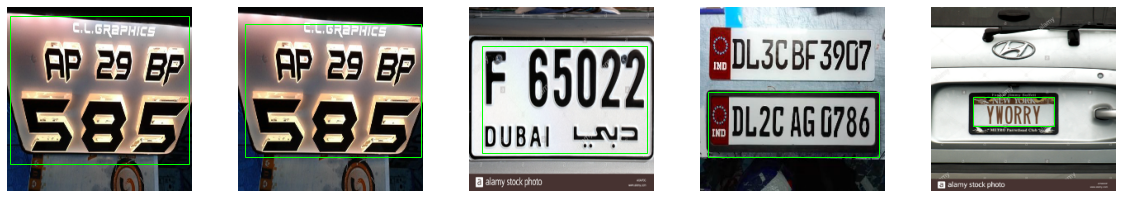

In [ ]:
plot_images(X, y, groups_features[7])

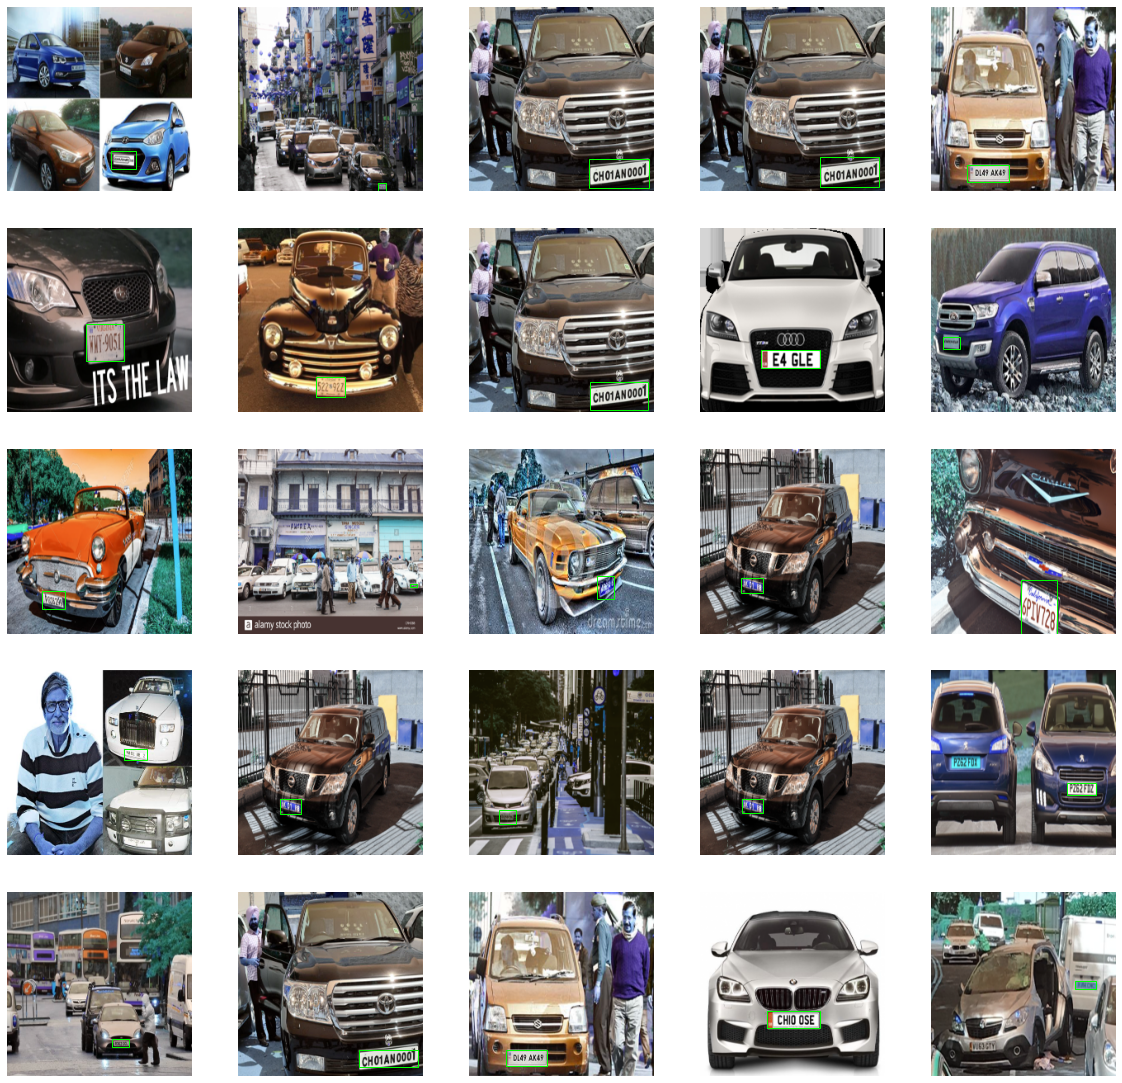

In [ ]:
plot_images(X, y, groups_features[6])

## Find cosine similarities

In [ ]:
features_compress = features.reshape(features.shape[0],
                                     features.shape[1]*features.shape[2]*features.shape[3])
similarities = cosine_similarity(features_compress)

In [ ]:
similarities[0].shape

(433,)

In [ ]:
topn = 10

In [ ]:
topn_sim = np.argsort(-similarities[topn], axis=0)[0:12]
topn_sim

array([297,  61, 368,  10, 222, 361, 118, 303, 278,  58, 264, 253])

In [ ]:
def plot_images(X, y, ids):
  fig = plt.figure(figsize=(20,40))
  id = 0
  for i in ids:
      axis = fig.add_subplot(10, 5, id+1)
      id += 1
      plt.axis('off')
      image = X_raw[i]

      rect_ori = create_rect(y[i]*IMAGE_SIZE, (0, 255/255, 0))
      axis.add_patch(rect_ori)
      plt.imshow(image)


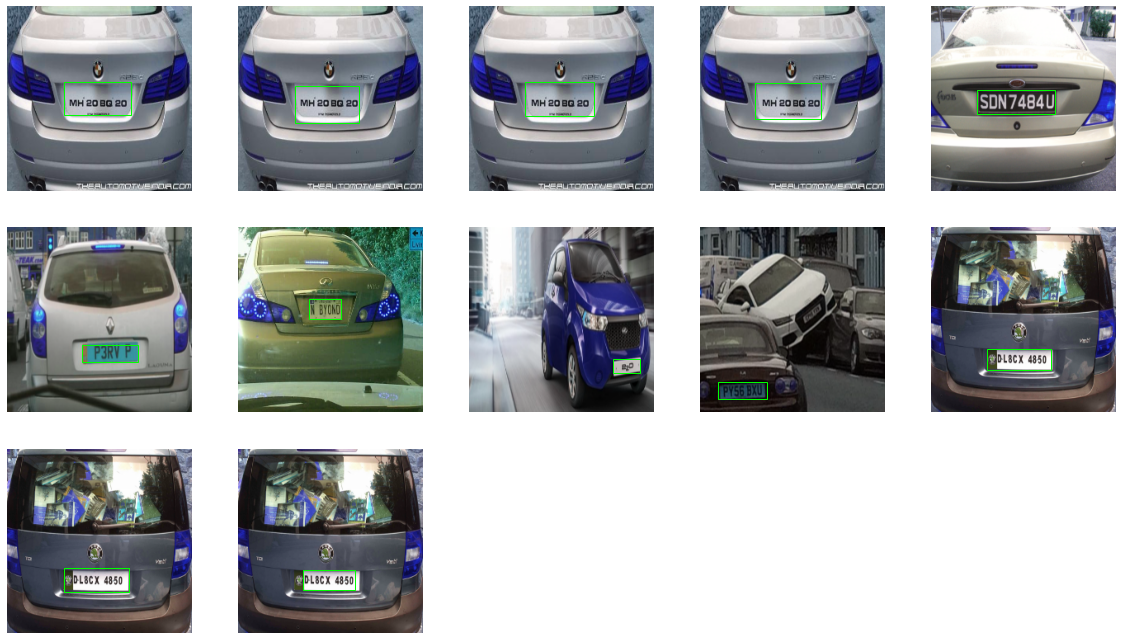

In [ ]:
plot_images(X, y, [297, 61, 368, 10, 222, 361, 118, 303, 278,  58, 264, 253])

# Bayesian
To start with, the following code is borrowed from 
https://keras.io/examples/keras_recipes/bayesian_neural_networks/ with some modifications.


## Priors and posteriors



In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

## Build the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

train_size = X_test.shape[0]

# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(tfp.layers.DenseVariational(
    units=128,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1/train_size,
    activation="relu"))
model.add(tfp.layers.DenseVariational(
    units=64,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1/train_size,
    activation="relu"))
model.add(tfp.layers.DenseVariational(
    units=4,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1/train_size,
    activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_variational (DenseVari (None, 128)               136347840 
_________________________________________________________________
dense_variational_1 (DenseVa (None, 64)                34093152  
_________________________________________________________________
dense_variational_2 (DenseVa (None, 4)                 34190     
Total params: 188,401,262
Trainab

In [ ]:
import datetime
import tensorflow as tf

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.save('my_model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 43.68%


In [ ]:
examples = X_test

def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )

compute_predictions(model)

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

# Reference
- [TensorFlow Probability regression tutorial](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)